In [105]:
import event_stochastic_ode as eso
import numpy as np
from matplotlib import pyplot as plt
import time

# Model of Campus Drinking 

We have the following rules from `CravingMoodandEncounters.ipynb`:

$$ \frac{dc}{dt} = c_{\text{slope}}c - m(t) $$

$$ \frac{dp}{dt}  = \gamma[-p + \sigma(p + bc)] $$

$$c(t_i) \leftarrow c(t_i) - c_{drink} \quad \text{if } t_i \in e $$

where $c$ represents craving, $p$ represents probability of drinking (if alcohol is encountered), $m(t)$ is given and represents mood, and $e$ is a given set of encounter times. 

Together these equations model an individual's drinking behavior.

Based on discussion with the lab we will add in a variable $s$ that will represent interest in social events which we will use to drive drinking in healthy people

We will also simplify the model slightly and have $s$ increase with positive mood.

### Healthy Drinker:

$$ \frac{ds}{dt} = s_{\text{slope}}s + m(t) $$

$$ \frac{dp}{dt}  = \gamma[-p + \sigma\,(a s) + b] $$

$$s(t_i) \leftarrow s(t_i) - s_{drink} \quad \text{if } t_i \in e $$


### Craving Driven Drinker


$$ \frac{dc}{dt} = c_{\text{slope}}c - m(t) $$

$$ \frac{dp}{dt}  = \gamma[-p + \sigma\,(a c) + b] $$

$$c(t_i) \leftarrow c(t_i) - c_{drink} \quad \text{if } t_i \in e $$

Here the only difference is that craving responds to negative mood. We will also need to adjust model parameters, $c_\text{slope}, c_\text{drink}, \gamma, a, b,$ and $e$ to produce the right kind of behavior. That is, these parameters may be drawn from different distributions for craving driven drinkers.

## Social Drinker Functions

In [77]:
def socialf(y, t, s_slope, s_drink, gamma, a, b, m):
    s, p, d = y
    ds = s_slope*s + m(t)
    dp = gamma * (-p + eso.sigmoid(a*s) + b)
    dd = 0
    return np.array([ds, dp, dd])
    
def social_event_rule(f, y, t, dt, params):
    s, p, d = y
    s_slope = params[0]
    if np.random.rand() < p:
            d = 1
            s -= s_drink
    else:
        d = 0
    return np.array([s, p, d])

def plot_sim(t, states, event_times, params):
    s_slope, s_drink, gamma, a, b, m = params
    plt.rcParams["figure.figsize"] = [12, 6]
    c = states[:, 0]
    p = states[:, 1]
    d = states[:, 2]
    event_spikes, drink_spikes = make_drink_spikes(event_times, d, t)
    plt.subplot(411)
    plt.plot(t, m(t), c="grey", alpha=0.5, label="Mood")
    plt.xticks([],[])
    plt.ylim(-1.2, 1.2)
    plt.legend()
    plt.subplot(412)
    plt.plot(t, c, c="pink", label="Craving")
    plt.xticks([],[])
    plt.legend()
    plt.subplot(413)
    plt.plot(t, p, c="lightgreen", label="Probability of drinking")
    plt.yticks([0, .5, 1])
    plt.xticks([], [])
    plt.legend()
    plt.subplot(414)
    plt.plot(t, event_spikes, c="orange", label="Drinking Opportunities", alpha=0.7)
    plt.plot(t, drink_spikes, c="darkgreen", label="Drinking behavior")
    plt.yticks([0, 1], ["Abstain", "Drink"])
    plt.ylim(-.2, 1.2)
    plt.xlabel("Day")
    plt.suptitle("One Month of Drinking Behavior")
    plt.tight_layout()
    plt.legend()
    plt.show()

## Social Drinker Parameters

In [56]:
def make_drink_spikes(event_times, drinks, t):
    """ Accept the output of a social/craving drinking model and returns
    a spike train of drinking opportunities and drinks, ready for plotting.
    
    Parameters
    ----------
    event_times (ndarray): a list of event times
    drinks (ndarray): drinking output of the model
    t (ndarray): times corresponding to the drinks array
    
    Returns
    -------
    opportunities (ndarray): zero/one array of length len(t) where ones 
        correspond to drinking opportunities
    drinkspikes   (ndarray): zero/one array of length len(t) where ones 
        correspond to drinks
    """
    opportunities = np.zeros_like(drinks)
    drinkspikes = np.zeros_like(drinks)
    dt = t[1] - t[0]
    for i, ti in enumerate(t):
        if eso.event(event_times, ti, dt):
            opportunities[i] = 1.0
            if drinks[i] == 1.0:
                drinkspikes[i] = 1.0
    return opportunities, drinkspikes

In [78]:
# Mood variability
A = 1.0
freq = 1.0
theta = 0
# Mood function
m = lambda t: A*np.sin(2*freq*np.pi*(t - theta))
# Encounter times
maxdays = 30
# e = np.arange(1.0, maxdays)
# e = np.array([])
e = eso.exponential_event_times(30)
# Decrease in craving upon drinking
s_drink = 0.5
# Slope of craving
s_slope = -1
# Weight of craving on probability of drinking
a = 20.0
b = 0.0
# Derivative magnitude
gamma = 10.0
# Package up parameters
params = (s_slope, s_drink, gamma, a, b, m)
# Initial conditions
y0 = np.array([0.0, 0.0, 0.0])
start = 0.0
end = maxdays
dt = 0.01

In [79]:
Y, t = eso.simulate(socialf, y0, start, end, dt, params, social_event_rule, e, method="rk4")

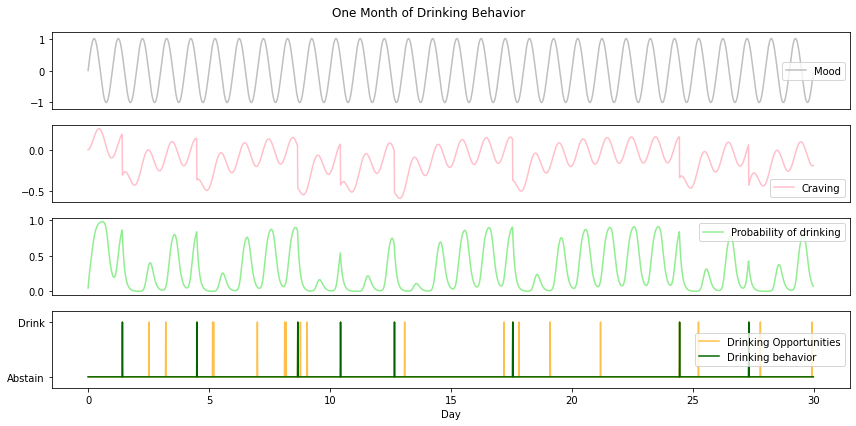

In [80]:
plot_sim(t, Y, e, params)

# Do values of $\gamma$ and $a$ impact drinks per day?

In [57]:
def drinks_per_day(t, states, event_times):
    """ Compute average drinks per day given the output of the model
    and the event times.
    
    Returns
    -------
    drinks_per_day (float):
    drinks_per_encounter (float): 
    """
    event_spikes, drink_spikes = make_drink_spikes(event_times, states[:, 2], t)
    drinks_per_day = np.sum(drink_spikes) / (t[-1]-t[0])
    drinks_per_encounter = np.sum(drink_spikes) / np.sum(event_spikes)
    return drinks_per_day, drinks_per_encounter

In [60]:
# Mood function
A = 1.0
freq = 1.0
theta = 0
# Mood function
mood = lambda t: A*np.sin(2*freq*np.pi*(t - theta))
# Encounter times
maxdays = 1000
# e = np.arange(1.0, maxdays)
# e = np.array([])
e = eso.exponential_event_times(maxdays)
# Decrease in craving upon drinking
s_drink = 0.5
# Slope of craving
s_slope = -1
# Weight of craving on probability of drinking
a = 0.0
b = 0.0
# Derivative magnitude
gamma = 1.0
# Package up parameters
params = (s_slope, s_drink, gamma, a, b, m)
# Initial conditions
y0 = np.array([0.0, 0.0, 0.0])
start = 0.0
end = maxdays
dt = 0.01

a_vals = [0.1, 0.5, 0.75, 1.0, 3.0, 5.0, 10.0, 12.0, 15.0, 20.0]
gamma_vals = [0.1, 0.5, 0.75, 1.0, 3.0, 5.0, 10.0, 12.0, 15.0, 20.0]
m, n = len(a_vals), len(gamma_vals)
D_per_day = np.zeros((m,n))
D_per_encounter = np.zeros((m,n))

for i, ai in enumerate(a_vals):
    for j, gi in enumerate(gamma_vals):
        e = eso.exponential_event_times(maxdays)
        params = (s_slope, s_drink, gi, ai, b, mood)
        Y, t = eso.simulate(socialf, y0, start, end, dt, params, social_event_rule, e, method="rk4")
        dpd, dpe = drinks_per_day(t, Y, e)
        D_per_day[i,j] = dpd
        D_per_encounter[i,j] = dpe

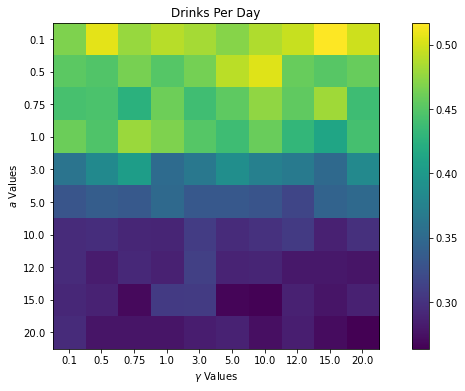

In [103]:
plt.imshow(D_per_day)
plt.colorbar()
plt.ylabel("$a$ Values")
plt.xlabel("$\gamma$ Values")
plt.yticks(range(10), a_vals)
plt.xticks(range(10), gamma_vals)
plt.title("Drinks Per Day")
plt.show()

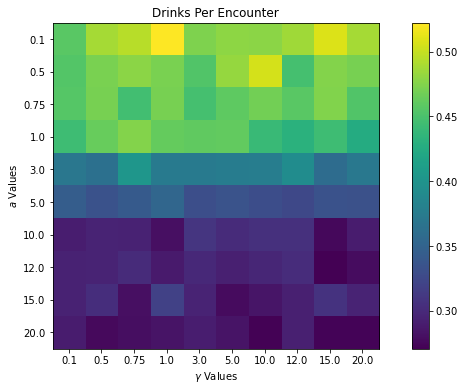

In [104]:
plt.imshow(D_per_encounter)
plt.colorbar()
plt.ylabel("$a$ Values")
plt.xlabel("$\gamma$ Values")
plt.yticks(range(10), a_vals)
plt.xticks(range(10), gamma_vals)
plt.title("Drinks Per Encounter")
plt.show()

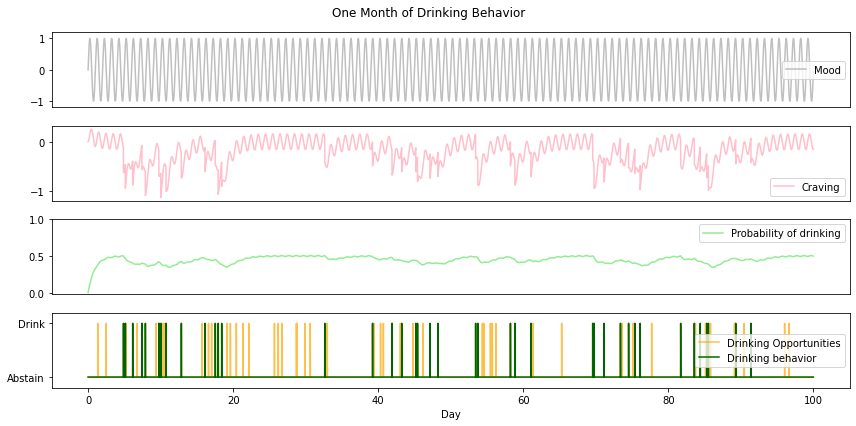

Drinks per day: 0.4000400040004
Drinks per encounter: 0.449438202247191


In [92]:
maxdays = 100
end = maxdays
a = 1.0
g = 1.0
e = eso.exponential_event_times(maxdays)
params = (s_slope, s_drink, g, a, b, mood)
Y, t = eso.simulate(socialf, y0, start, end, dt, params, social_event_rule, e, method="rk4")
plot_sim(t, Y, e, params)
dpd, dpe = drinks_per_day(t, Y, e)
print(f"Drinks per day: {dpd}")
print(f"Drinks per encounter: {dpe}")

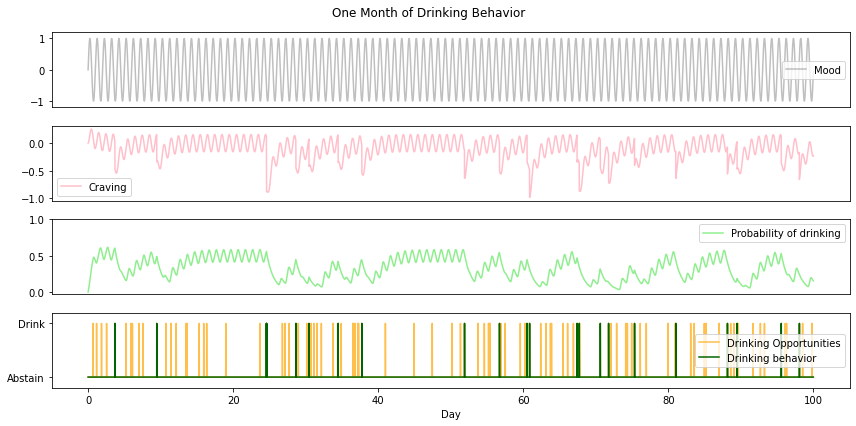

Drinks per day: 0.22002200220022
Drinks per encounter: 0.20952380952380953


In [93]:
a = 20.0
g = 1.0
e = eso.exponential_event_times(maxdays)
params = (s_slope, s_drink, g, a, b, mood)
Y, t = eso.simulate(socialf, y0, start, end, dt, params, social_event_rule, e, method="rk4")
plot_sim(t, Y, e, params)
dpd, dpe = drinks_per_day(t, Y, e)
print(f"Drinks per day: {dpd}")
print(f"Drinks per encounter: {dpe}")

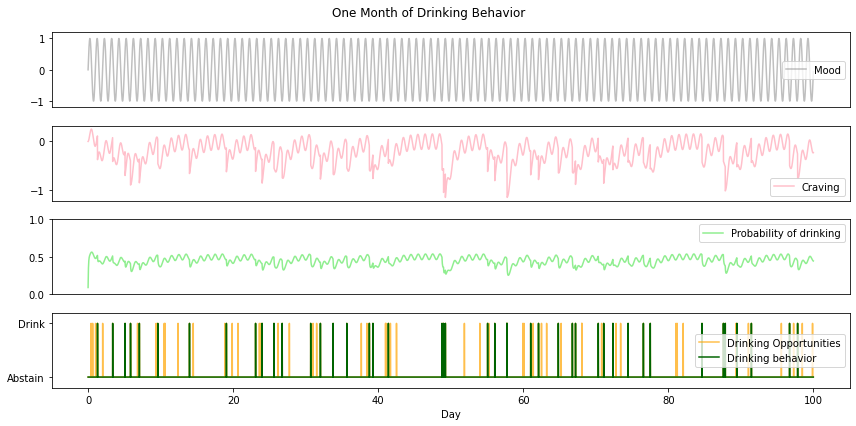

Drinks per day: 0.44004400440044
Drinks per encounter: 0.46808510638297873


In [94]:
a = 1.0
g = 20.0
e = eso.exponential_event_times(maxdays)
params = (s_slope, s_drink, g, a, b, mood)
Y, t = eso.simulate(socialf, y0, start, end, dt, params, social_event_rule, e, method="rk4")
plot_sim(t, Y, e, params)
dpd, dpe = drinks_per_day(t, Y, e)
print(f"Drinks per day: {dpd}")
print(f"Drinks per encounter: {dpe}")

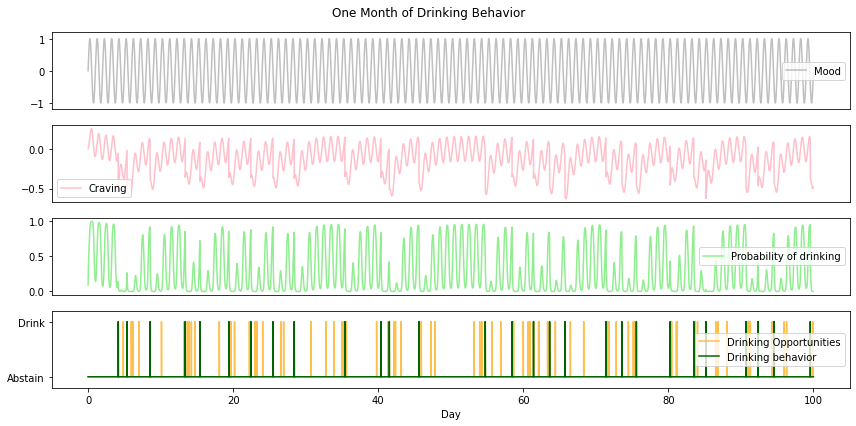

Drinks per day: 0.28002800280028
Drinks per encounter: 0.27450980392156865


In [95]:
a = 20.0
g = 20.0
e = eso.exponential_event_times(maxdays)
params = (s_slope, s_drink, g, a, b, mood)
Y, t = eso.simulate(socialf, y0, start, end, dt, params, social_event_rule, e, method="rk4")
plot_sim(t, Y, e, params)
dpd, dpe = drinks_per_day(t, Y, e)
print(f"Drinks per day: {dpd}")
print(f"Drinks per encounter: {dpe}")

The $s_\text{drink}$ parameter only comes into effect when $a$ is large. Otherwise, $p$ stays pretty much constant at $b + 0.5$. For some reason, increasing gamma doesn't have an effect on drinks per day. Is this because of the uniformity of our mood function?

# Is there an interaction between $b$ and $\gamma$ when $a$ is high?

In [120]:
# Mood function
A = 1.0
freq = 1.0
theta = 0
# Mood function
mood = lambda t: A*np.sin(2*freq*np.pi*(t - theta))
# Encounter times
maxdays = 1000
# e = np.arange(1.0, maxdays)
# e = np.array([])
e = eso.exponential_event_times(maxdays)
# Decrease in craving upon drinking
s_drink = 0.5
# Slope of craving
s_slope = -1
# Weight of craving on probability of drinking
a = 20.0
b = 0.0
# Derivative magnitude
gamma = 1.0
# Package up parameters
params = (s_slope, s_drink, gamma, a, b, m)
# Initial conditions
y0 = np.array([0.0, 0.0, 0.0])
start = 0.0
end = maxdays
dt = 0.01

b_vals = np.arange(-.5, 0.5, .1)
gamma_vals = [0.1, 0.5, 0.75, 1.0, 3.0, 5.0, 10.0, 12.0, 15.0, 20.0]
m, n = len(b_vals), len(gamma_vals)
D_per_day = np.zeros((m,n))
D_per_encounter = np.zeros((m,n))

t0 = time.time()
for i, bi in enumerate(b_vals):
    for j, gi in enumerate(gamma_vals):
        e = eso.exponential_event_times(maxdays)
        params = (s_slope, s_drink, gi, a, bi, mood)
        Y, t = eso.simulate(socialf, y0, start, end, dt, params, social_event_rule, e, method="rk4")
        dpd, dpe = drinks_per_day(t, Y, e)
        D_per_day[i,j] = dpd
        D_per_encounter[i,j] = dpe

print(f"Elapsed time: {time.time() - t0}")

Elapsed time: 481.27898478507996


Time for one especially long run: 4698 seconds. One hour and 15 min to run 1000 simulations of three years of drinking

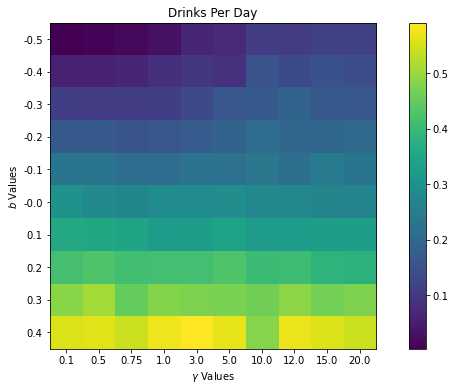

In [125]:
plt.imshow(D_per_day)
plt.colorbar()
plt.ylabel("$b$ Values")
plt.xlabel("$\gamma$ Values")
plt.yticks(range(m), np.round(b_vals,2))
plt.xticks(range(n), gamma_vals)
plt.title("Drinks Per Day")
plt.show()

Here we see a slight interaction between $b$ and $\gamma$. When $b$ is small, a high $\gamma$ leads to an increased drinks per day, however, this effect is less pronounced as $b$ increases.

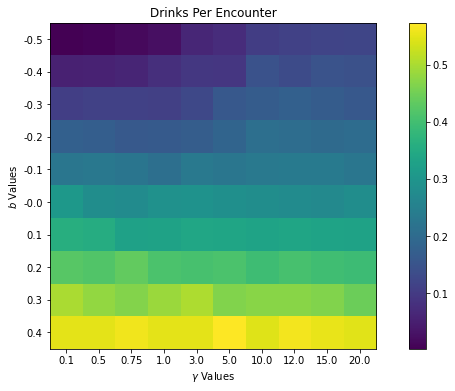

In [128]:
plt.imshow(D_per_encounter)
plt.colorbar()
plt.ylabel("$b$ Values")
plt.xlabel("$\gamma$ Values")
plt.yticks(range(m), np.round(b_vals,2))
plt.xticks(range(n), gamma_vals)
plt.title("Drinks Per Encounter")
plt.show()

I think the reason that drinks per day never gets larger than one is because on average the individual only encounters one drink per day. I'm guessing that we could get more drinks per day with more opportunities per day, and that it would scale exactly with the scale parameter provided to the exponential distribution during event time generation.

# Is there an interaction between $s_\text{drink}$ and $\gamma$ when $a$ is high?

In [129]:
# Mood function
A = 1.0
freq = 1.0
theta = 0
# Mood function
mood = lambda t: A*np.sin(2*freq*np.pi*(t - theta))
# Encounter times
maxdays = 1000
# e = np.arange(1.0, maxdays)
# e = np.array([])
e = eso.exponential_event_times(maxdays)
# Decrease in craving upon drinking
s_drink = 0.0
# Slope of craving
s_slope = -1
# Weight of craving on probability of drinking
a = 20.0
b = 0.0
# Derivative magnitude
gamma = 1.0
# Package up parameters
params = (s_slope, s_drink, gamma, a, b, m)
# Initial conditions
y0 = np.array([0.0, 0.0, 0.0])
start = 0.0
end = maxdays
dt = 0.01

sd_vals = [-5.0, -3.0, -2.0, -2.5, -2.0, -1.5, -1.0, -.5, -0.25, 0.25]
gamma_vals = [0.1, 0.5, 0.75, 1.0, 3.0, 5.0, 10.0, 12.0, 15.0, 20.0]
m, n = len(sd_vals), len(gamma_vals)
D_per_day = np.zeros((m,n))
D_per_encounter = np.zeros((m,n))

t0 = time.time()
for i, si in enumerate(sd_vals):
    for j, gi in enumerate(gamma_vals):
        e = eso.exponential_event_times(maxdays)
        params = (s_slope, si, gi, a, b, mood)
        Y, t = eso.simulate(socialf, y0, start, end, dt, params, social_event_rule, e, method="rk4")
        dpd, dpe = drinks_per_day(t, Y, e)
        D_per_day[i,j] = dpd
        D_per_encounter[i,j] = dpe

print(f"Elapsed time: {time.time() - t0}")

Elapsed time: 2288.087383031845


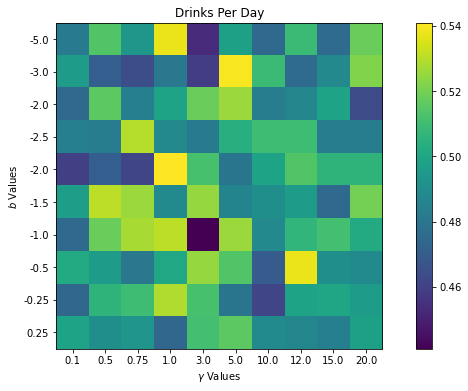

In [131]:
plt.imshow(D_per_day)
plt.colorbar()
plt.ylabel("$s_\\text{drink}$ Values")
plt.xlabel("$\gamma$ Values")
plt.yticks(range(m), sd_vals)
plt.xticks(range(n), gamma_vals)
plt.title("Drinks Per Day")
plt.show()

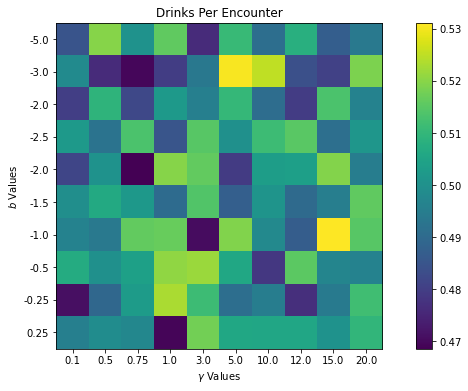

In [132]:
plt.imshow(D_per_encounter)
plt.colorbar()
plt.ylabel("$s_\\text{drink}$ Values")
plt.xlabel("$\gamma$ Values")
plt.yticks(range(m), sd_vals)
plt.xticks(range(n), gamma_vals)
plt.title("Drinks Per Encounter")
plt.show()

In [148]:
print(f"Row averages: {np.round(D_per_day.mean(axis=1),2)}")
print(f"Column averages: {np.round(D_per_day.mean(axis=0),2)}")
print(f"All param average: {D_per_day.mean()}")

Row averages: [0.5  0.49 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.49]
Column averages: [0.48 0.5  0.5  0.51 0.49 0.51 0.49 0.5  0.49 0.5 ]
All param average: 0.49703497034970345


So we conclude that $\gamma$ and $s_\text{drink}$ have no effect on mean drinking. Let's look at why.

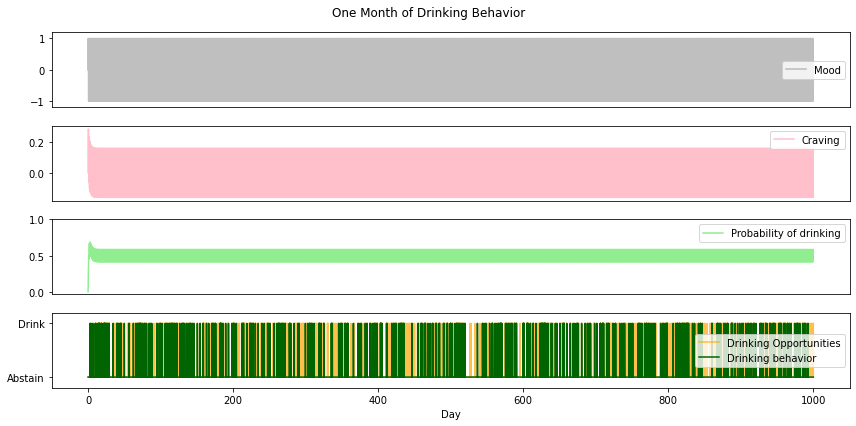

Drinks per day: 0.45800458004580047
Drinks per encounter: 0.47216494845360824


In [146]:
a = 20.0
g = 1.0
s_slope = -0.5
maxdays = 1000
e = eso.exponential_event_times(maxdays)
params = (s_slope, s_drink, g, a, b, mood)
Y, t = eso.simulate(socialf, y0, start, end, dt, params, social_event_rule, e, method="rk4")
plot_sim(t, Y, e, params)
dpd, dpe = drinks_per_day(t, Y, e)
print(f"Drinks per day: {dpd}")
print(f"Drinks per encounter: {dpe}")

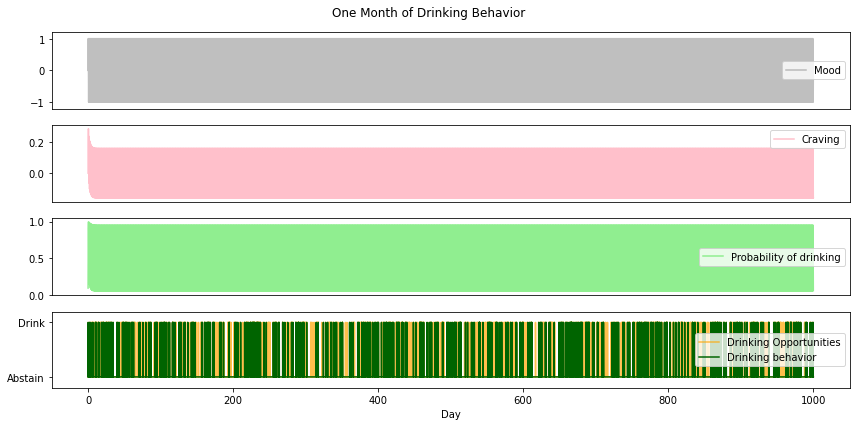

Drinks per day: 0.4970049700497005
Drinks per encounter: 0.49403578528827036


In [143]:
a = 20.0
g = 20.0
s_slope = -0.5
maxdays = 1000
e = eso.exponential_event_times(maxdays)
params = (s_slope, s_drink, g, a, b, mood)
Y, t = eso.simulate(socialf, y0, start, end, dt, params, social_event_rule, e, method="rk4")
plot_sim(t, Y, e, params)
dpd, dpe = drinks_per_day(t, Y, e)
print(f"Drinks per day: {dpd}")
print(f"Drinks per encounter: {dpe}")

In [145]:
np.mean(Y, axis=0)

array([3.15516743e-04, 5.00726020e-01, 5.00810000e-01])

Why does gamma have no effect on mean drinking? Because you are just as likely to be in a good mood as you are to be in a bad mood?